In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sp_io
import bct
import bct_duzc

import warnings
warnings.filterwarnings("ignore")

In [2]:
example_rewired_connectomes = sp_io.loadmat("./data/example_rewired_connectomes.mat")['example_rewired_connectomes']
coordinates = sp_io.loadmat("./data/dk_coordinates.mat")['coordinates']

# Weighted to binary network

In [3]:
n_sub = example_rewired_connectomes.shape[0]
n_node = example_rewired_connectomes.shape[1]
n_edge = n_node * (n_node - 1) // 2
thr = 27
n_sub, n_node, n_edge, thr

(270, 68, 2278, 27)

In [4]:
density = []
binarised_connectomes = []
for i in range(n_sub):
    W_thr = example_rewired_connectomes[i, :, :].copy()
    W_thr[W_thr<thr] = 0
    density.append( (np.triu(W_thr, 1) > 0).sum() / n_edge )
    B = np.zeros(W_thr.shape)
    B[W_thr>0] = 1
    binarised_connectomes.append(B)

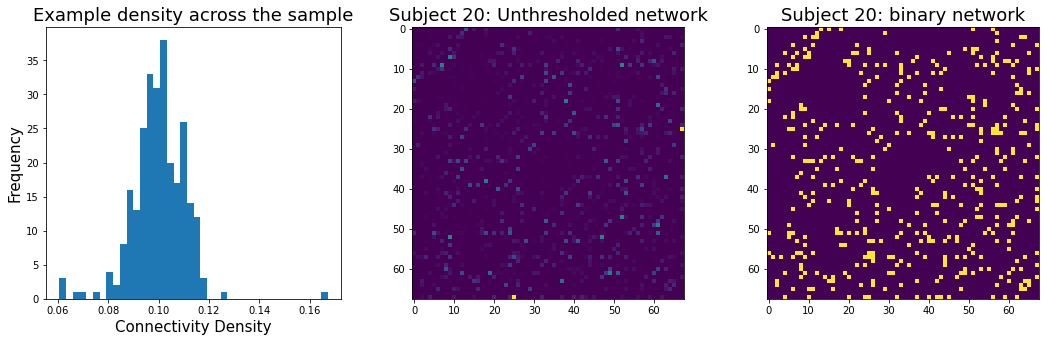

In [5]:
subVis = 20
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(density, bins=40)
plt.xlabel('Connectivity Density', size=15)
plt.ylabel('Frequency', size=15)
plt.title('Example density across the sample', size=18)

plt.subplot(1, 3, 2)
plt.imshow(example_rewired_connectomes[subVis, :, :])
plt.title(f'Subject {subVis}: Unthresholded network', size=18)

plt.subplot(1, 3, 3)
plt.imshow(binarised_connectomes[subVis])
plt.title(f'Subject {subVis}: binary network', size=18)

plt.show()
plt.close()

# Generate seed network

In [6]:
proportion = 0.2
Atgt_set = np.array(binarised_connectomes)
connections = Atgt_set.mean(axis=0)
A = np.zeros(connections.shape)
A[connections==proportion] = 1

In [7]:
degree = (A>0).sum(axis=0)

In [8]:
nz = (Atgt_set.sum(axis=(1, 2)) // 2).astype(int)

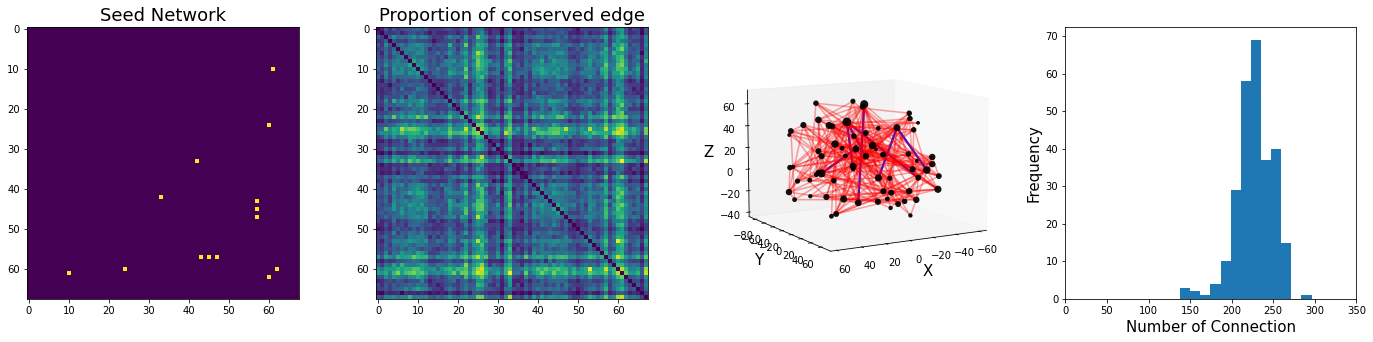

In [9]:
plt.figure(figsize=(24, 5))

plt.subplot(1, 4, 1)
plt.imshow(A)
plt.title('Seed Network', size=18)

plt.subplot(1, 4, 2)
plt.imshow(connections)
plt.title('Proportion of conserved edge', size=18)

ax = plt.subplot(1, 4, 3, projection='3d')
subVis = 120
sub_network = binarised_connectomes[subVis]
sub_degree = (sub_network>0).sum(axis=0).reshape((-1, 1))
sub_edge = np.array([ (coordinates[u], coordinates[v]) for u, v in np.argwhere(sub_network) ])
init_edge = np.array([ (coordinates[u], coordinates[v]) for u, v in np.argwhere(A) ])

ax.grid(False)
ax.view_init(elev=10, azim=60)
ax.scatter(*coordinates.T, s=sub_degree*3+2, c='black', alpha=0.9)
for edge in init_edge:
    ax.plot(*edge.T, color="blue", alpha=0.75, lw=2)
for edge in sub_edge:
    ax.plot(*edge.T, color="red", alpha=0.2)
ax.set_xlabel('X', size=15)
ax.set_ylabel('Y', size=15)
ax.set_zlabel('Z', size=15)

plt.subplot(1, 4, 4)
plt.hist(nz, bins=20)
plt.xlim(0, 350)
plt.xlabel("Number of Connection", size=15)
plt.ylabel("Frequency", size=15)

plt.show()
plt.close()

# Run generative model

In [10]:
import scipy.spatial as sp_spatial

In [11]:
D = sp_spatial.distance.squareform(sp_spatial.distance.pdist(coordinates, metric="euclidean"))
model_type = ['euclidean', 'neighbors', 'matching', 
             'clu-avg', 'clu-min', 'clu-max', 'clu-diff', 'clu-prod',
             'deg-avg', 'deg-min', 'deg-max', 'deg-diff', 'deg-prod']
model_var  = ['powerlaw', 'powerlaw']

eta_limits = [-7, 7] 
gam_limits = [-7, 7]
n_run = 64
eta = np.linspace(eta_limits[0], eta_limits[1], num=np.sqrt(n_run).astype(int) )
gam = np.linspace(gam_limits[0], gam_limits[1], num=np.sqrt(n_run).astype(int) )
p, q = np.meshgrid(eta, gam)
params = np.array([p.ravel(), q.ravel()]).T
n_params = params.shape[0]

In [14]:
def calc_ks_stat(t1, t2):
    bin_edges = np.concatenate( ([-np.Inf], np.sort(np.concatenate([t1, t2])), [np.Inf]) )
    bin_x, _ = np.histogram(t1, bin_edges)
    bin_y, _ = np.histogram(t2, bin_edges)
    sum_x = bin_x.cumsum()/bin_x.sum()
    sum_y = bin_y.cumsum()/bin_y.sum()
    return np.abs(sum_x[:-1] - sum_y[:-1]).max()

def synth_network_dat_iter(dat):
    for i in range(dat.shape[-1]):
        yield dat[:, :, i]

synth_all, K_all, E_all = {}, {}, {}
for i in range(2):
    synth_all[i], K_all[i], E_all[i] = [], [], []
    
    Atgt = binarised_connectomes[i]
    m = nz[i]
    n = Atgt.shape[0]
    x = [Atgt.sum(axis=1), 
         bct.clustering_coef_bu(Atgt), 
         bct.betweenness_bin(Atgt), 
         D[np.triu(Atgt, k=1).astype(bool)] ]
    np.disp(f"running generative model for subject {i}")
    
    for mt in model_type:
        B = bct_duzc.generative_model(A.copy(), D, m, eta=params[:, 0], gamma=params[:, 1], model_type=mt, model_var=model_var[0]) # 返回值是各种参数下生成的网络
        KS_stat = []
        for b in synth_network_dat_iter(B):
            y = [b.sum(axis=1),
                 bct.clustering_coef_bu(b),
                 bct.betweenness_bin(b), 
                 D[np.triu(b, k=1).astype(bool)] ]
            KS_stat.append( [ calc_ks_stat(t1, t2)   for t1, t2 in zip(x, y) ])
        
        synth_all[i].append(B)
        KS_stat = np.array(KS_stat)
        K_all[i].append( KS_stat )
        E_all[i].append( KS_stat.max(axis=1) )
        #break
    #break

running generative model for subject 0
running generative model for subject 1


## Exploring Generative model outputs

In [16]:
generative10000_energy = sp_io.loadmat("./data/generative10000_energy.mat")["generative10000_energy"]
generative10000_parameters = sp_io.loadmat("./data/generative10000_parameters.mat")["generative10000_parameters"]
generative50000_energy = sp_io.loadmat("./data/generative50000_energy.mat")['generative50000_energy']
generative50000_ks = sp_io.loadmat("./data/generative50000_ks.mat")['generative50000_ks']
generative50000_parameters = sp_io.loadmat("./data/generative50000_parameters.mat")['generative50000_parameters']

In [21]:
generative10000_energy.shape, generative10000_parameters.shape, generative50000_energy.shape, generative50000_ks.shape, generative50000_parameters.shape

((270, 13, 10000),
 (270, 13, 10000, 2),
 (270, 50040),
 (270, 50040, 4),
 (270, 50040, 2))

In [36]:
e = generative10000_energy[:, :, 0]
p1 = generative10000_parameters[:, :, 0, 0]
p2 = generative10000_parameters[:, :, 0, 1]

In [55]:
networktable = pd.DataFrame([ model_type, e.mean(axis=0), e.std(axis=0), p1.mean(axis=0), p1.std(axis=0), p2.mean(axis=0), p2.std(axis=0)]).T
networktable.columns = ['Rule', 'Mean E', 'Std E', 'Mean P1', 'Std P1', 'Mean P2', 'Std P2']
np.disp(networktable)

         Rule    Mean E     Std E   Mean P1    Std P1   Mean P2    Std P2
0   euclidean   0.33759  0.020029 -3.939693   0.39702  0.349345  3.939998
1   neighbors  0.165417  0.020349 -1.994463  0.483067  0.338346  0.045446
2    matching  0.141124  0.021211 -1.647213  0.490332  0.357202  0.022473
3     clu-avg  0.181125   0.01585 -3.070258  0.377984 -6.202843  0.734831
4     clu-min  0.251576  0.020497 -3.625963  0.395571 -6.130565  0.795413
5     clu-max  0.182379  0.014494 -3.094875  0.387177 -6.152563  0.735212
6    clu-diff  0.322193  0.025279 -6.192892  0.744218 -3.479835  2.017705
7    clu-prod  0.223433  0.023637 -3.400748  0.393151  -5.96401  0.926008
8     deg-avg  0.220993  0.018657 -3.515975   0.50215  2.419229  0.332469
9     deg-min   0.27872  0.015885  -4.74942  0.749037  0.473999  0.099651
10    deg-max  0.215844  0.019247 -3.556828  0.602143  2.255294  0.332067
11   deg-diff  0.229222  0.017859  -3.83599  0.669029  1.689113   0.57685
12   deg-prod  0.276768  0.018079 -4.6

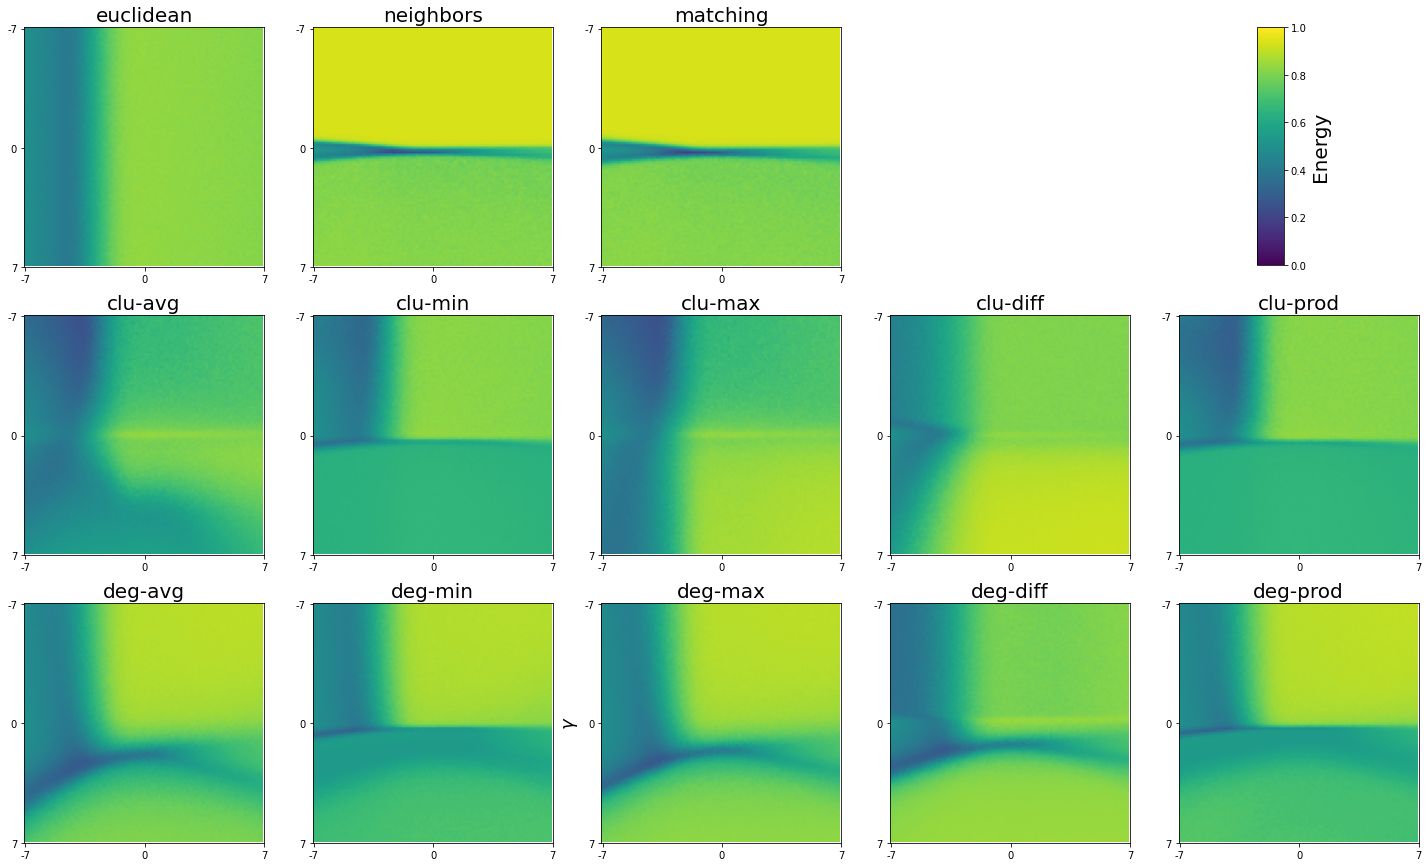

In [165]:
plt.figure(figsize=(25, 15))
for m, mt in enumerate(model_type):
    energy_landscape = 0
    for sub in range(n_sub):
        subj_energy = generative10000_energy[sub, m, :]
        subj_params = generative10000_parameters[sub, m, :, :]
        u, idx = np.unique(subj_params, return_index=True, axis=0)
        uniq_eta = np.unique(u[:, 0]).shape[0]
        uniq_gam = np.unique(u[:, 1]).shape[0]
        
        energy_landscape += subj_energy[idx, ].reshape((uniq_gam, uniq_eta))
        #break
    energy_landscape /= n_sub
    
    if m < 3:
        plot_loc = m+1
    else:
        plot_loc = m+3
    plt.subplot(3, 5, plot_loc)
    plt.imshow(energy_landscape.T, vmin=0, vmax=1)
    if plot_loc == 5:
        plt.xlabel("$\eta$", size=18)
    elif plot_loc == 13:
        plt.ylabel("$\gamma$", size=18)
    plt.xticks(ticks=[0, 50, 100], labels=[-7, 0, 7], size=10)
    plt.yticks(ticks=[0, 50, 100], labels=[-7, 0, 7], size=10)
    plt.title(mt, size=20)
  
plt.subplot(3, 5, 5)
plt.axis(False)
cbar = plt.colorbar(cax=plt.axes([0.81, 0.66, 0.015, 0.22]))
cbar.set_label("Energy", size=20)
plt.show()
plt.close()

In [166]:
plt.violinplot?

Signature:
plt.violinplot(
    dataset,
    positions=None,
    vert=True,
    widths=0.5,
    showmeans=False,
    showextrema=True,
    showmedians=False,
    quantiles=None,
    points=100,
    bw_method=None,
    *,
    data=None,
)
Docstring:
Make a violin plot.

Make a violin plot for each column of *dataset* or each vector in
sequence *dataset*.  Each filled area extends to represent the
entire data range, with optional lines at the mean, the median,
the minimum, the maximum, and user-specified quantiles.

Parameters
----------
dataset : Array or a sequence of vectors.
  The input data.

positions : array-like, default: [1, 2, ..., n]
  Sets the positions of the violins. The ticks and limits are
  automatically set to match the positions.

vert : bool, default: True.
  If true, creates a vertical violin plot.
  Otherwise, creates a horizontal violin plot.

widths : array-like, default: 0.5
  Either a scalar or a vector that sets the maximal width of
  each violin. The default is

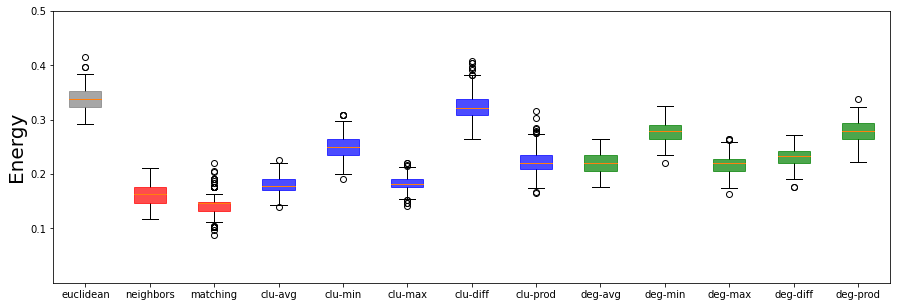

In [202]:
color = ['gray'] + ['red']*2 + ['blue']*5 + ['green'] * 5
plt.figure(figsize=(15, 5))
bp = plt.boxplot(e, patch_artist=True)
for i, c in enumerate(color):
    bp['boxes'][i].set(alpha=0.7, color=color[i])

plt.xticks(np.arange(1, 14), model_type)
plt.ylim(0, 0.5)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5 ], [0.1, 0.2, 0.3, 0.4, 0.5 ])
plt.ylabel("Energy", size=20)
plt.show()
plt.close()

Object `plt.color` not found.


In [197]:
bp['boxes'][i].set(color='blue')

[None]

In [ ]:
bp['boxes'][i].set

In [ ]:
bp['boxes'].set